In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [21]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [22]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date'>

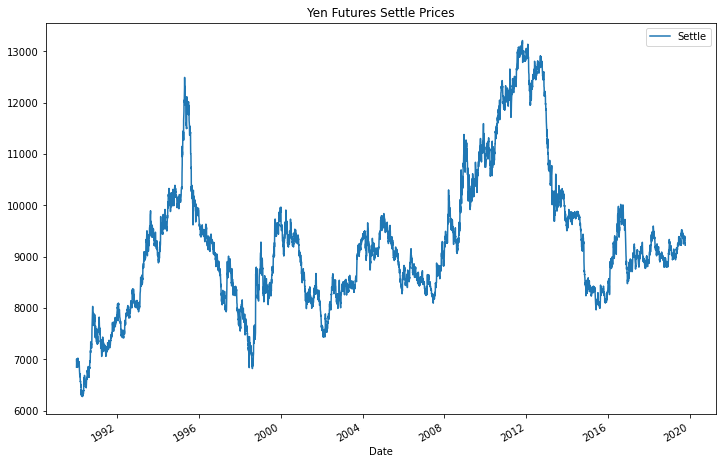

In [23]:
# Plot just the "Settle" column from the dataframe:
yen_futures[["Settle"]].plot(figsize=(12, 8), title="Yen Futures Settle Prices")

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [24]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [25]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
futures_decomp = yen_futures[["Settle"]].copy()
futures_decomp["noise"] = ts_noise
futures_decomp["trend"] = ts_trend
futures_decomp.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='Date'>

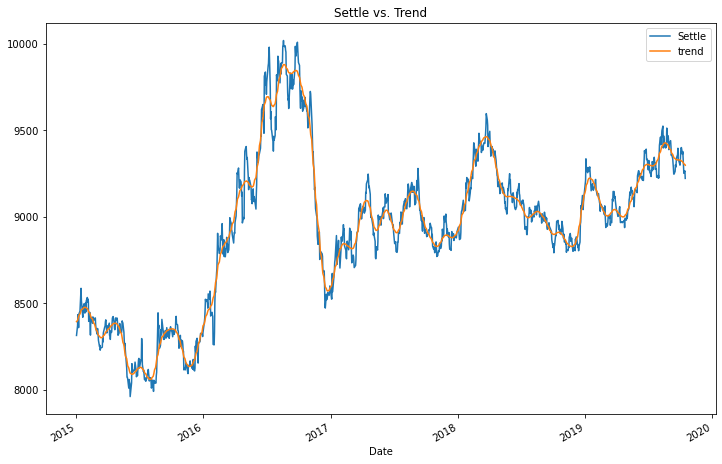

In [26]:
# Plot the Settle Price vs. the Trend for 2015 to the present
futures_decomp[["Settle", "trend"]]["2015-01-01":].plot(figsize=(12, 8), title="Settle vs. Trend")

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

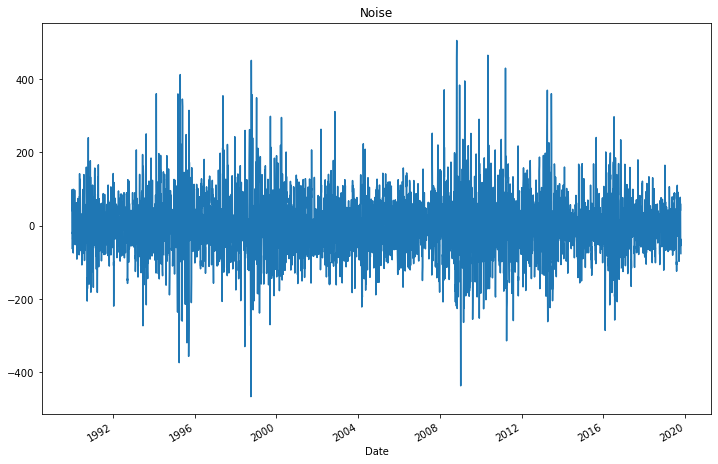

In [27]:
 # Plot the Settle Noise
ts_noise.plot(figsize=(12, 8), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [28]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [29]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = sm.tsa.ARMA(returns, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency infor

In [30]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 15 Mar 2022   AIC                          15798.142
Time:                        19:47:56   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3064      1.277     -0.240      0.810      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2949      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3326           +0.0000j            3.3326            0.5000
AR.2         -157.0960           +0.0000j          157.0960            0.5000
MA.1           -3.3914           +0.0000j            3.3914            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

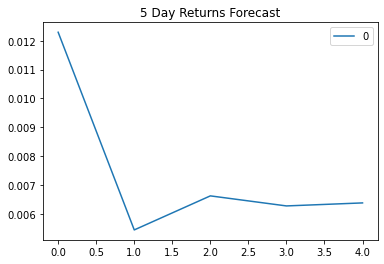

In [31]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures[["Settle"]], order=(5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency infor

In [33]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 15 Mar 2022   AIC                          83905.238
Time:                        19:48:01   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.668       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3787j            2.3409           -0.1002
AR.2            1.8918           +1.3787j            2.3409            0.1002
AR.3           -2.2705           -3.0203j            3.7785           -0.3526
AR.4           -2.2705           +3.0203j            3.7785            0.3526
AR.5          -11.0834           -0.0000j           11.0834           -0.5000
MA.1            3.3643           +0.0000j            3.3643            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forcast(steps=5)[0].plot(title="5 Day Futures Price Forcast")

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_12364/3927165218.py, line 2)

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [35]:
import arch 

In [37]:
 # Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87406254.62884925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.925448485285
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.715051647085
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.8233985962215
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.046068867134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.737484233749
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.4113697930225
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.2146776534555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021535648443
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935930634227
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898024664
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643351801
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640221216
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4239912

In [ ]:
# Summarize the model results
results.summary()

In [ ]:
 # Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
focasts = retults.forcast(start=last_day, horizon=forecast_horizon

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title=:"5 Day Forcast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

After running the analysis, it would make sense to purchase the yen now. 

In [ ]:
Risk: the level on this mode high. 

In [ ]:
Base on the model evaluation, I would be 50% confident in this model. This means, I would keep a close eyes on the model. 